# 루브릭

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.	
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.	
모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.	 
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

In [225]:
from importlib.metadata import version
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

 ## Step 1. 데이터 수집하기
 
- 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [226]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_all = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [227]:
data_all.sample(10)

,headlines,text
31372,Not my birthday but looking forward to Mother'...,Talking about her birthday falling on the same...
6300,"TMC leader, 2 others killed in bomb attack nea...",A Trinamool Congress leader and two other peop...
7153,Aus scientists develop 10-minute test for all ...,Researchers from Australia's University of Que...
22757,Ex-world no. 1 Murray jumps 457 spots to no. 3...,"Three-time Grand Slam winner Andy Murray, who ..."
29107,I'm the most popular Afghan after President: R...,"Afghanistan's 19-year-old spinner Rashid Khan,..."
78123,Wheelchair tennis player won Wimbledon title w...,Britain's Jordanne Whiley has revealed that sh...
35894,Oil firms weren't directed to absorb fuel pric...,Oil Minister Dharmendra Pradhan has said that ...
73905,India will not witness total solar eclipse for...,"India, having witnessed the last total solar e..."
84828,Winking Ronaldo mural created near Portugal te...,A mural of footballer Cristiano Ronaldo winkin...
69135,150 people trapped after dam collapses in Maha...,Around 150 people were reportedly trapped afte...


In [228]:
data['text'] = data_all['text'] # text 부분만 추출
data['title'] = data_all['headlines'] # headlines 부분만 추출
data.head()

,text,title,decoder_input,decoder_target
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...",sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


## Step 2. 데이터 전처리하기 (추상적 요약)

- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [229]:
print('전체 샘플수 :', (len(data)))
print('text 열에서 중복을 배제한 유일한 샘플의 수 :',
      data['text'].nunique())
print('head 열에서 중복을 배제한 유일한 샘플의 수 :',
      data['title'].nunique())

전체 샘플수 : 98343
text 열에서 중복을 배제한 유일한 샘플의 수 : 98343
head 열에서 중복을 배제한 유일한 샘플의 수 : 98245


In [230]:
# 중복열 제거
# 다른 내용으로 헤드라인이 같은 경우가 있을 수 있으므로 text만 중복제거

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98343


In [231]:
print(data.isnull().sum()) # 결측치 갯수 계산 // 결측치 없음

text              0
title             0
decoder_input     0
decoder_target    0
dtype: int64


In [232]:
# 동일한 의미의 텍스트 제거 ex) it'll = it will

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [233]:
# 불용어 리스트 (stopwords는 nltk.corpus 의 모듈)
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [234]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (head)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [235]:
# 전처리 진행
# text 전처리 / 불용어제거
clean_text = []
for text in data.text :
    clean_text.append(preprocess_sentence(text, remove_stopwords=True))

In [236]:
# head 전처리  / 불용어제거x
clean_title = []
for title in data.title :
    clean_title.append(preprocess_sentence(title, remove_stopwords=False)) 

In [237]:
# 전처리 결과 반영하여 저장

data['text'] = clean_text
data['title'] = clean_title

In [238]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [239]:
print("전처리 후 결과: ", data.head())

전처리 후 결과:                                                  text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
1  kunal shah credit card bill payment platform c...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
4  speaking sexual harassment allegations rajkuma...   

                                               title  \
0  upgrad learner switches to career in ml al wit...   
1  delhi techie wins free food from swiggy for on...   
2  new zealand end rohit sharma led india match w...   
3  aegon life iterm insurance plan helps customer...   
4  have known hirani for yrs what if metoo claims...   

                                       decoder_input  \
0  sostoken upgrad learner switches to career in ...   
1  sostoken delhi techie wins free food from swig...   
2  sostoken new zealand end rohit sharma led indi...   
3  sostoken aegon life iterm insurance plan helps...   
4  sostoken have known hirani for y

In [240]:
# 전처리 후 결측치 확인

data.isnull().sum()

text              0
title             0
decoder_input     0
decoder_target    0
dtype: int64

In [241]:
# 없지만 그냥 해준다..

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


In [242]:
# 혹시모르니 전처리 결과물 저장
data.to_csv('/aiffel/aiffel/workplace/AiffelEX/ex12/ex12_clean.csv', index=False)

In [243]:
data.head()

,text,title,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 50
텍스트의 평균 길이 : 35.09718027719309
요약의 최소 길이 : 1
요약의 최대 길이 : 15
요약의 평균 길이 : 9.299268885431601


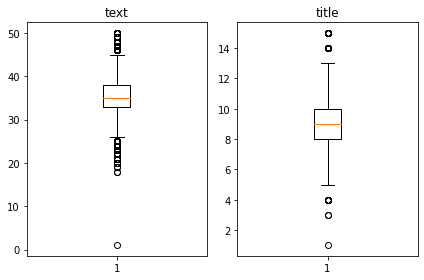

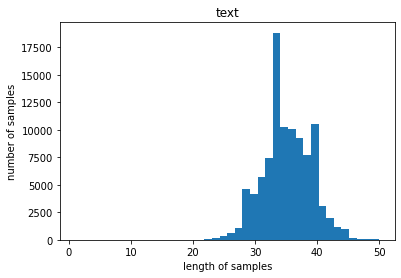

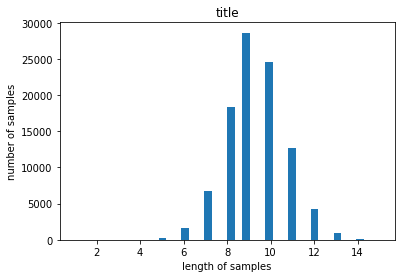

In [244]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
title_len = [len(s.split()) for s in data['title']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(title_len)))
print('요약의 최대 길이 : {}'.format(np.max(title_len)))
print('요약의 평균 길이 : {}'.format(np.mean(title_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(title_len)
plt.title('title')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('title')
plt.hist(title_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [245]:
# 길이 분포 확인

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [246]:
# 보수적으로 샘플 비율 99%에서 컷

text_max_len = 50
title_max_len = 15
below_threshold_len(text_max_len, data['text'])
below_threshold_len(title_max_len, data['title'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 15 이하인 샘플의 비율: 1.0


In [247]:
# 샘플 길이가 이상치인 경우 제거

data = \
data[data['text'].apply(lambda x : len(x.split()) <= text_max_len)]
data = \
data[data['title'].apply(lambda x : len(x.split()) <= title_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


In [248]:
# max_cut 후 저장

data.to_csv('/aiffel/aiffel/workplace/AiffelEX/ex12/ex12_maxcut.csv', index=False)

In [249]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
# 디코더는 시작토큰과 종료토근을 줘야 시작,종료지점이 설정된다
data['decoder_input'] = data['title'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['title'].apply(lambda x : x + ' eostoken')
data.head()

,text,title,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [250]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
# 샘플크기의 무작위 indices 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)


In [ ]:
# 셔플된 indices를 이용하여 인풋 순서 섞어주기(행 연결은 유지)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [253]:
# 훈련데이터 중 검증데이터 0.2배수 선별

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19668


In [254]:
# 훈련데이터 중 검증데이터 0.2배수 선별

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [255]:
src_tokenizer = Tokenizer() # 토크나이저 정의 # 단어 집합의 크기 제한x
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [256]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# key : 단어 / value : 빈도수
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69620
등장 빈도가 6번 이하인 희귀 단어의 수: 47445
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22175
단어 집합에서 희귀 단어의 비율: 68.14852054007468
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4867225677054345


In [257]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [258]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[50, 1175, 143, 556, 1693, 2710, 1322, 7671, 70, 257, 3167, 727, 2073, 1, 3167, 2648, 411, 9806, 392, 7671, 629, 2189, 29, 197, 3651, 280, 8548, 65, 4], [5, 34, 5890, 3182, 432, 9295, 109, 291, 52, 598, 293, 446, 380, 109, 778, 32, 5890, 630, 118, 365, 2482, 98, 252, 9295, 3116, 5890, 347, 3117, 3273, 12947, 3182, 1483, 436, 66, 945], [35, 937, 4366, 50, 398, 70, 1381, 7922, 5833, 75, 42, 5613, 9462, 1775, 2053, 6114, 13815, 7672, 839, 9627, 2285, 6408, 600, 256, 5496, 12948, 12949, 301, 218, 398, 1]]


In [259]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) #디코드 값으로 훈련

In [260]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30063
등장 빈도가 5번 이하인 희귀 단어의 수: 19638
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10425
단어 집합에서 희귀 단어의 비율: 65.32282207364534
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.633445704160353


In [261]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2139, 1717, 3, 666, 517, 7, 155, 9, 4144], [1, 6474, 72, 148, 4, 344, 624, 5, 5422, 282, 169], [1, 265, 3685, 8800, 3, 2484, 2328, 198, 4, 26, 2057], [1, 2396, 1103, 2397, 180, 43, 286, 713, 262], [1, 1584, 256, 1870, 1985, 2228, 3, 2329, 4265, 346]]
target
decoder  [[2139, 1717, 3, 666, 517, 7, 155, 9, 4144, 2], [6474, 72, 148, 4, 344, 624, 5, 5422, 282, 169, 2], [265, 3685, 8800, 3, 2484, 2328, 198, 4, 26, 2057, 2], [2396, 1103, 2397, 180, 43, 286, 713, 262, 2], [1584, 256, 1870, 1985, 2228, 3, 2329, 4265, 346, 2]]


In [262]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우,
# 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 
# 이 샘플들은 모두 삭제할 거예요.


drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [263]:
# 지정된 최대길이로 패딩 / 최대 길이보다 짧은 데이터는 뒤에 0을 넣어 패딩

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=title_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=title_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=title_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=title_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [264]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# [[YOUR CODE]]
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
# [[YOUR CODE]]
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [265]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [266]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [267]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [268]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 44s 126ms/step - loss: 4.5646 - val_loss: 4.2111
Epoch 2/50
308/308 [==============================] - 37s 119ms/step - loss: 4.0603 - val_loss: 3.8869
Epoch 3/50
308/308 [==============================] - 37s 120ms/step - loss: 3.7747 - val_loss: 3.6621
Epoch 4/50
308/308 [==============================] - 37s 120ms/step - loss: 3.5661 - val_loss: 3.5162
Epoch 5/50
308/308 [==============================] - 37s 120ms/step - loss: 3.4011 - val_loss: 3.3993
Epoch 6/50
308/308 [==============================] - 37s 120ms/step - loss: 3.2660 - val_loss: 3.3122
Epoch 7/50
308/308 [==============================] - 37s 120ms/step - loss: 3.1471 - val_loss: 3.2385
Epoch 8/50
308/308 [==============================] - 37s 120ms/step - loss: 3.0454 - val_loss: 3.1845
Epoch 9/50
308/308 [==============================] - 37s 120ms/step - loss: 2.9562 - val_loss: 3.1392
Epoch 10/50
308/308 [==============================] - 37s 120ms/step - l

### 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인

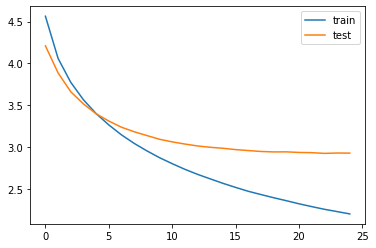

In [269]:
# 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [270]:
# 실제 데이터로 복원하기 위한 필요한 3개의 사전 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음



In [271]:
'''
정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 
디코더가 반복 구조로 동작해야 하기 때문에 
부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 
이때는 인코더 모델과 디코더 모델을 분리해서 설계

'''

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



In [272]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [273]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (title_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [274]:
'''
seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 
seq2summary 함수 코드를 작성하세요.
(힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)
'''

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    summary = ''
    for i in input_seq:
        if (i != 0 and i != tar_tokenizer.word_index['sostoken']) and i != tar_tokenizer.word_index['eostoken']:
            summary = summary + tar_index_to_word.get(i, '') + ' '
    return summary


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)


- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [275]:
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : shahid kapoor kiara advani starring recreation prabhudeva song urvashi tamil film later dubbed hindi new urvashi song written sung yo yo honey singh talking song kiara said could ode prabhu sir huge fan 
실제 요약 : shahid kiara in of song urvashi 
예측 요약 :  shahid kapoor sings song from upcoming film released


원문 : ahead general elections pakistan candidate cricketer turned politician imran khan party pti killed suicide attack wounded four others earlier pakistan national counter terrorism authority warned serious security threats political leaders major parties saying terrorists could use suicide bombers target politicians 
실제 요약 : candidate from imran khan party killed in suicide attack 
예측 요약 :  pak army chief calls for encounter in pulwama


원문 : delhi metro rail corporation ltd wednesday installed nobel memorial wall rajiv chowk metro station seventh consecutive year temporary wall features portraits indian nobel prize winners spread awareness contribution society wall installed

## Step 5. Summa을 이용해서 추출적 요약해보기

- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

- Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [276]:
import requests
from summa.summarizer import summarize

In [277]:
text = data_all['text'][0]
print(text)

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


In [278]:
print("원문 :", seq2text(encoder_input_train[0]))
print("실제 요약 :", seq2summary(decoder_input_train[0]))
print("예측 요약 :", decode_sequence(encoder_input_train[0].reshape(1, text_max_len)))
print("\n")

원문 : actor ranbir kapoor reacting criticism rumoured girlfriend mahira khan received smoking wearing dress said smoking hate health gotten know mahira personal capacity last months unfair way judged woman added 
실제 요약 : smoking hate to health ranbir on pic with mahira 
예측 요약 :  ranbir slams ranbir for smoking smoking in pic of ranbir




In [279]:
# 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 
# 원문의 0.005%만을 출력하도록 설정
print('text :')
print(text)
print('Summary :')
print(summarize(text, ratio=0.5))

text :
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Summary :
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [280]:
print('Summary :')
print(summarize(text, ratio=0.5, split=True))

Summary :
["upGrad's Online Power Learning has powered 3 lakh+ careers."]


In [281]:
print('Summary :')
print(summarize(text, words=10))

Summary :
upGrad's Online Power Learning has powered 3 lakh+ careers.
